## Spotify Hit Predictor

In [5]:
# Importing required packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Data Processing

In [6]:
# I have created a CSV file containing tracks from the Billboard Hot 100 Charts (last 12 years) and a random selection of tracks which didn't feature on the charts

df = pd.read_csv("combined_data.csv", encoding="latin1")
df.head()

,rank,song,artist,spotify_uri,popularity,duration_ms,explicit,release_date,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,artist_popularity,year
0,1.0,"""Somebody That I Used to Know""",Gotye featuring Kimbra,spotify:track:2EDJkuEd5tvxSAPiXCHACe,51,318052,0,01/01/2012,0.00127,0.790,0.625,0.000807,0.0786,-6.691,0.0680,128.975,0.773,68.0,2012
1,2.0,"""Call Me Maybe""",Carly Rae Jepsen,spotify:track:20I6sIOMTCkB6w7ryavxtO,81,193400,0,01/01/2012,0.01140,0.783,0.580,0.000002,0.1080,-6.548,0.0408,120.021,0.660,74.0,2012
2,3.0,"""We Are Young""",Fun featuring Janelle MonÃ¡e,spotify:track:5rgy6ghBq1eRApCkeUdJXf,77,250626,0,14/02/2012,0.02000,0.378,0.638,0.000077,0.0849,-5.576,0.0750,184.086,0.735,67.0,2012
3,4.0,"""Payphone""",Maroon 5 featuring Wiz Khalifa,spotify:track:1XGmzt0PVuFgQYYnV2It7A,85,231173,1,01/01/2012,0.01880,0.743,0.752,0.000000,0.2870,-4.813,0.0414,110.015,0.545,86.0,2012
4,5.0,"""Lights""",Ellie Goulding,spotify:track:4QCnMOWxfDkTsGt82HULFb,65,245853,0,20/03/2020,0.07710,0.699,0.732,0.001980,0.1310,-6.307,0.0304,120.028,0.676,80.0,2020


In [7]:
# Datatype check

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33771 entries, 0 to 33770
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               1188 non-null   float64
 1   song               33771 non-null  object 
 2   artist             33771 non-null  object 
 3   spotify_uri        33771 non-null  object 
 4   popularity         33771 non-null  int64  
 5   duration_ms        33771 non-null  int64  
 6   explicit           33771 non-null  int64  
 7   release_date       33771 non-null  object 
 8   acousticness       33771 non-null  float64
 9   danceability       33771 non-null  float64
 10  energy             33771 non-null  float64
 11  instrumentalness   33771 non-null  float64
 12  liveness           33771 non-null  float64
 13  loudness           33771 non-null  float64
 14  speechiness        33771 non-null  float64
 15  tempo              33771 non-null  float64
 16  valence            337

In [8]:
# All datatypes look good except 'explicit' which needs to be boolean

df['explicit'] = df['explicit'].astype('bool')

In [9]:
# Duplicates check

# Checking for duplicates as I have combined tracks from two datasets
# The 'spotify_uri' column can be used as a unique identifier

duplicates = df[df.duplicated(subset='spotify_uri', keep=False)]['spotify_uri'].value_counts()
print("Count of duplicate values:")
print(duplicates)

Count of duplicate values:
2bRKxuH1o7pTmb1y4GfdEc    8
04Gv6iKKvurUaZcIwKnlUj    8
6OuJ13pokL5y3ojs13Nopn    8
36IXRA44nUFUD5qwZ0L4hf    8
1SZh3eUOXgzLqZ19mQlIQ9    8
                         ..
1lPGxDeTa2v3DKeWL1f1Ov    2
3Z44iTJ82FCCvupkymzuEp    2
3wnR4FIaT8Ok3gJjStIkyV    2
7ogqidU5KkUWxRDgWwRkVt    2
2yZax79pOrYuyIFVW2cZY2    2
Name: spotify_uri, Length: 3070, dtype: int64


In [10]:
duplicate_sum = df[df.duplicated(subset='spotify_uri', keep=False)].groupby('spotify_uri').size().sum()
print("Sum of occurrences of duplicate values:", duplicate_sum)

Sum of occurrences of duplicate values: 9680


In [11]:
# I want to get rid of duplicates but retain the tracks with non-null 'rank' values as these are hits from the Billboard charts

# Sort the DataFrame to prioritize non-blank 'rank' values
df_sorted = df.sort_values(by='rank', ascending=True)

# Drop duplicates based on 'spotify_uri' while keeping the first occurrence
df_unique = df_sorted.drop_duplicates(subset='spotify_uri', keep='first')

# Ensuring all duplicates have been removed
duplicate_sum_new = df_unique[df_unique.duplicated(subset='spotify_uri', keep=False)].groupby('spotify_uri').size().sum()
print("Sum of occurrences of duplicate values:", duplicate_sum_new)

Sum of occurrences of duplicate values: 0


In [12]:
# Nulls check

df_unique.isna().sum()

rank                 26052
song                     0
artist                   0
spotify_uri              0
popularity               0
duration_ms              0
explicit                 0
release_date             0
acousticness             0
danceability             0
energy                   0
instrumentalness         0
liveness                 0
loudness                 0
speechiness              0
tempo                    0
valence                  0
artist_popularity    26052
year                     0
dtype: int64

In [13]:
# 'rank' - nulls are songs that didn't feature on the Billboard Hot 100 in this period. I will use this information to create my binary output column

# 'artist_popularity' - due to the high number of nulls, it makes sense to drop this column

df_unique = df_unique.drop('artist_popularity', axis=1)

In [14]:
df_unique.shape

(27161, 18)

In [15]:
df_unique.describe()

,rank,popularity,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,year
count,1109.000000,27161.000000,2.716100e+04,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000,27161.000000
mean,49.779982,45.422481,2.357781e+05,0.488423,0.474934,0.478781,0.337235,0.185588,-11.530195,0.077874,113.721886,0.384751,1996.754538
std,29.097408,24.509020,1.389957e+05,0.400416,0.174023,0.290430,0.426481,0.152992,7.672164,0.088301,34.141545,0.249180,30.208766
min,1.000000,0.000000,8.853000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,1905.000000
25%,24.000000,37.000000,1.806000e+05,0.059400,0.356000,0.223000,0.000000,0.099800,-15.946000,0.035600,86.001000,0.177000,1983.000000
50%,50.000000,53.000000,2.141470e+05,0.451000,0.502000,0.482000,0.000734,0.122000,-8.787000,0.044800,110.007000,0.353000,2013.000000
75%,75.000000,63.000000,2.571200e+05,0.936000,0.609000,0.730000,0.880000,0.214000,-5.714000,0.072200,137.315000,0.563000,2016.000000
max,100.000000,100.000000,5.403500e+06,0.996000,0.977000,1.000000,1.000000,0.994000,0.457000,0.954000,221.058000,0.988000,2023.000000


In [16]:
# Create the 'hit' column - binary classification output variable

df_unique['hit'] = df_unique['rank'].notnull().astype(bool)

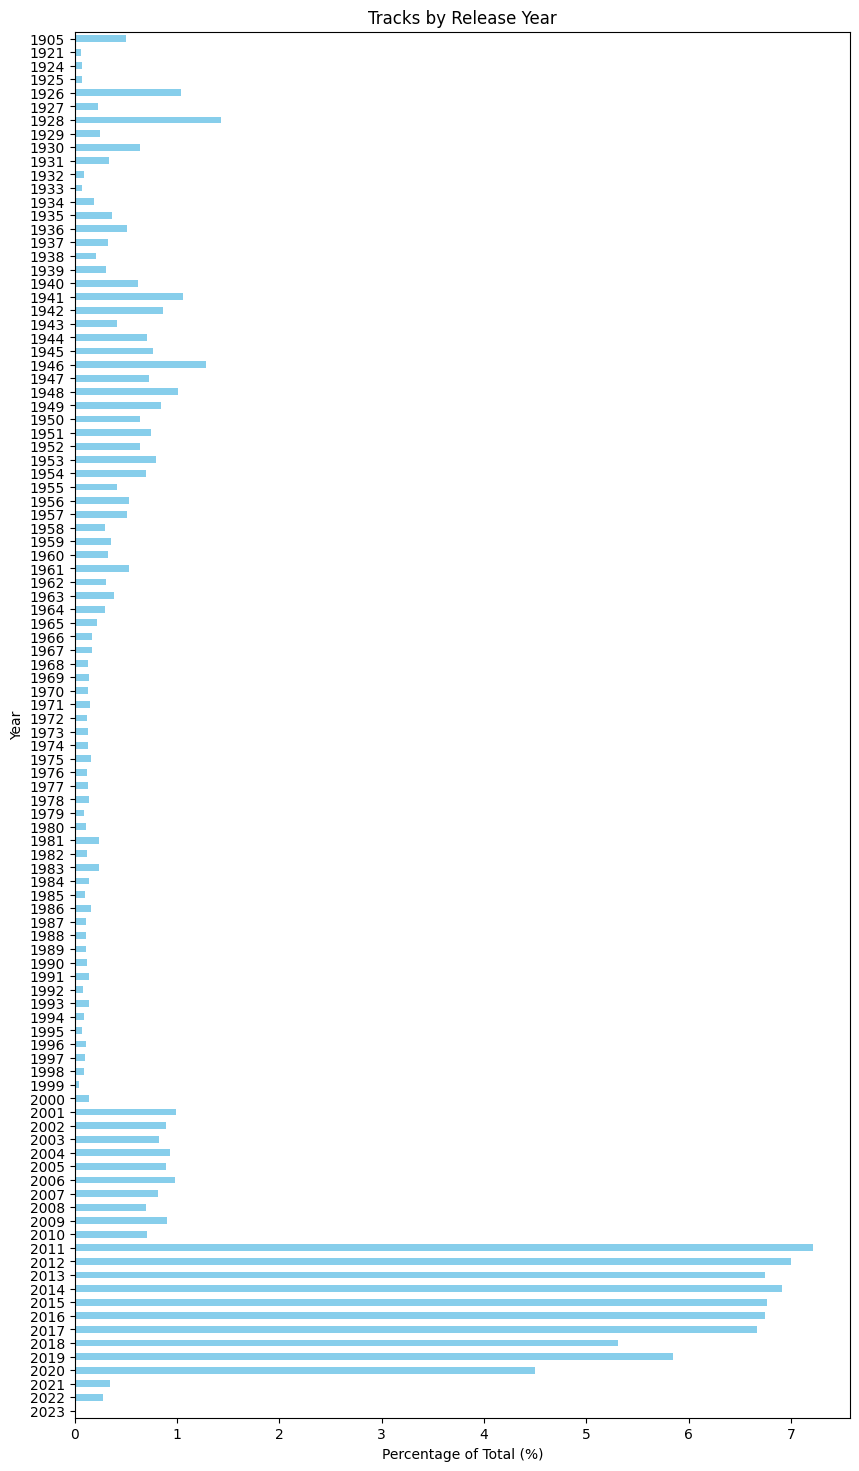

In [17]:
# Calculate the value counts for 'year'
year_counts = df_unique['year'].value_counts().sort_index(ascending=False)

# Calculate the percentage of each year in the total
year_percentage = year_counts / len(df_unique) * 100

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 18))
year_percentage.plot(kind='barh', color='skyblue')
plt.xlabel('Percentage of Total (%)')
plt.ylabel('Year')
plt.title('Tracks by Release Year')
plt.show()


In [18]:
# Songs from 1905 seem rather strange, I'm curious

df_unique[df_unique['year'] == 1905]

,rank,song,artist,spotify_uri,popularity,duration_ms,explicit,release_date,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,year,hit
297,3.0,"""See You Again""",Wiz Khalifa featuring Charlie Puth,spotify:track:2JzZzZUQj3Qff7wapcbKjc,83,229525,False,2015,0.369000,0.689,0.4810,0.000001,0.0649,-7.503,0.0815,80.025,0.2830,1905,True
110,12.0,"""Ho Hey""",The Lumineers,spotify:track:1K3LRUEcUz5FMtPYyg0F45,80,163133,False,2012,0.765000,0.682,0.4710,0.000000,0.0908,-9.182,0.0301,79.907,0.4210,1905,True
210,14.0,"""Am I Wrong""",Nico & Vinz,spotify:track:1fidCEsYlaVE3pHwKCvpFZ,78,245866,False,2014,0.175000,0.729,0.6750,0.000002,0.5500,-6.003,0.0312,119.968,0.7790,1905,True
1013,23.0,"""Running Up That Hill (A Deal with God)""",Kate Bush,spotify:track:75FEaRjZTKLhTrFGsfMUXR,86,298933,False,1985,0.720000,0.629,0.5470,0.003140,0.0604,-13.123,0.0550,108.375,0.1970,1905,True
127,29.0,"""Safe and Sound""",Capital Cities,spotify:track:6Z8R6UsFuGXGtiIxiD8ISb,83,192789,False,2013,0.000176,0.655,0.8190,0.003740,0.1040,-4.852,0.0316,117.956,0.7660,1905,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16106,NaN,Tiempo De Vals,['Chayanne'],6MfrzCRWvSYdCMuFk5ZRne,44,247733,False,2002,0.808000,0.256,0.3330,0.000000,0.1220,-10.600,0.0352,166.591,0.3070,1905,False
16108,NaN,Handel / Orch. Hale: Keyboard Suite in D Minor...,"['George Frideric Handel', 'Alexander Briger',...",1upQiytDIEZfl9ItruoXuC,66,207267,False,2002,0.927000,0.204,0.0331,0.825000,0.0954,-24.044,0.0487,116.200,0.0547,1905,False
20684,NaN,My Demons,['STARSET'],3Xfg7AegXaDLoD5GOUMf2e,72,288036,False,2014,0.007680,0.274,0.6520,0.000064,0.1080,-6.196,0.0625,173.008,0.1000,1905,False
22303,NaN,Kathleen,['Josh Ritter'],2nrVWS45ufhqJuKK95J3nv,53,248454,False,2003,0.055700,0.264,0.6480,0.000005,0.0980,-7.643,0.0637,52.365,0.4080,1905,False


In [19]:
# Looks like tracks with YYYY only instead of the entire date in 'release_date' have been assigned 1905
# But the 'release_date' contains the true value, I can update them using these values

# Filter rows where 'year' is 1905
rows_to_update = df_unique[df_unique['year'] == 1905]

# Update the 'year' column with the corresponding 'release_date'
df_unique.loc[rows_to_update.index, 'year'] = rows_to_update['release_date']

In [20]:
# Date-time modifications

# Convert the 'year' column to datetime
df_unique['year'] = pd.to_datetime(df_unique['year'], format='%Y')

# Extract the year component from the datetime objects and update the 'year' column
df_unique['year'] = df_unique['year'].dt.year

In [21]:
# I want to stick to tracks released in this time period to avoid music trends that have changed over time

# Filter the DataFrame for the years between 2010 and 2020
df_filtered = df_unique[(df_unique['year'] > 2010) & (df_unique['year'] < 2021)]

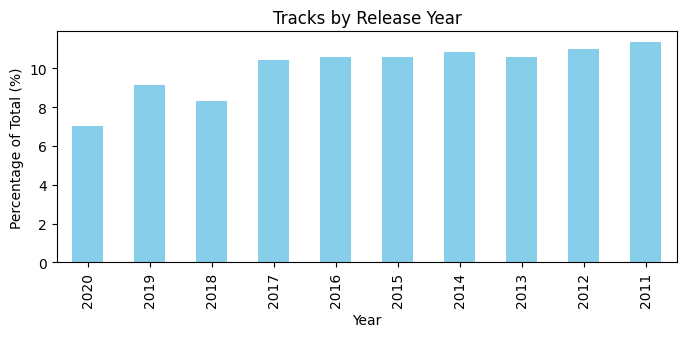

In [22]:
# Calculate the value counts for 'year'
year_counts = df_filtered['year'].value_counts().sort_index(ascending=False)

# Calculate the percentage of each year of the total
year_percentage = year_counts / len(df_filtered) * 100

# Plotting the bar chart
plt.figure(figsize=(8, 3))
year_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Percentage of Total (%)')
plt.title('Tracks by Release Year')
plt.show()


In [23]:
# Class imbalance check

print(df_filtered['hit'].value_counts(normalize=True))

False    0.947718
True     0.052282
Name: hit, dtype: float64


In [24]:
# The dataset is heavily imbalanced, I will undersample the majority class later on to fix this

### Data Exploration

In [25]:
# Select the features
features = ['acousticness', 'loudness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'explicit']

num_features = ['acousticness', 'loudness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']

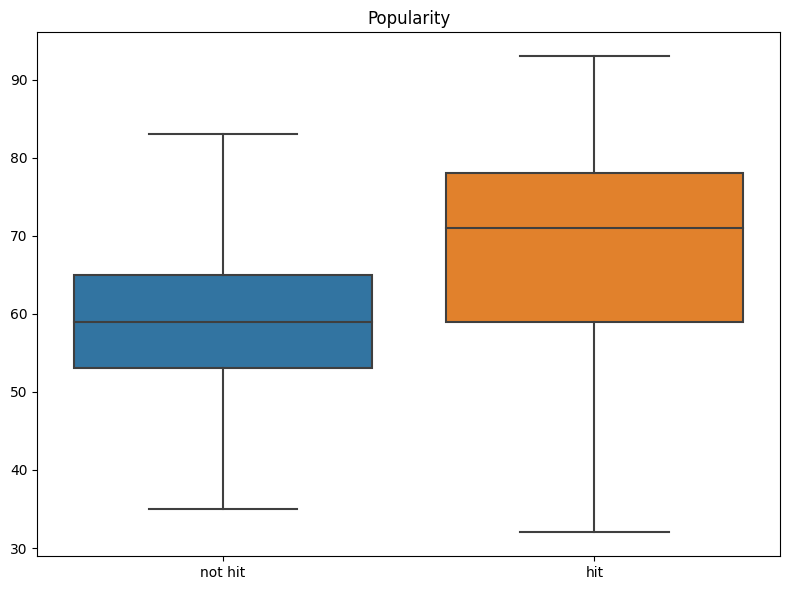

In [26]:
# Data leakage check
# I have exluded popularity although it is a clear indicator, as this information wouldn't be available when a song is released

plt.figure(figsize=(8, 6))
sns.boxplot(x='hit', y='popularity', data=df_filtered, showfliers=False)
plt.title("Popularity")

# Set custom x-axis labels
plt.xticks(ticks=[0, 1], labels=['not hit', 'hit'])

# Hide x and y-axis labels
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()

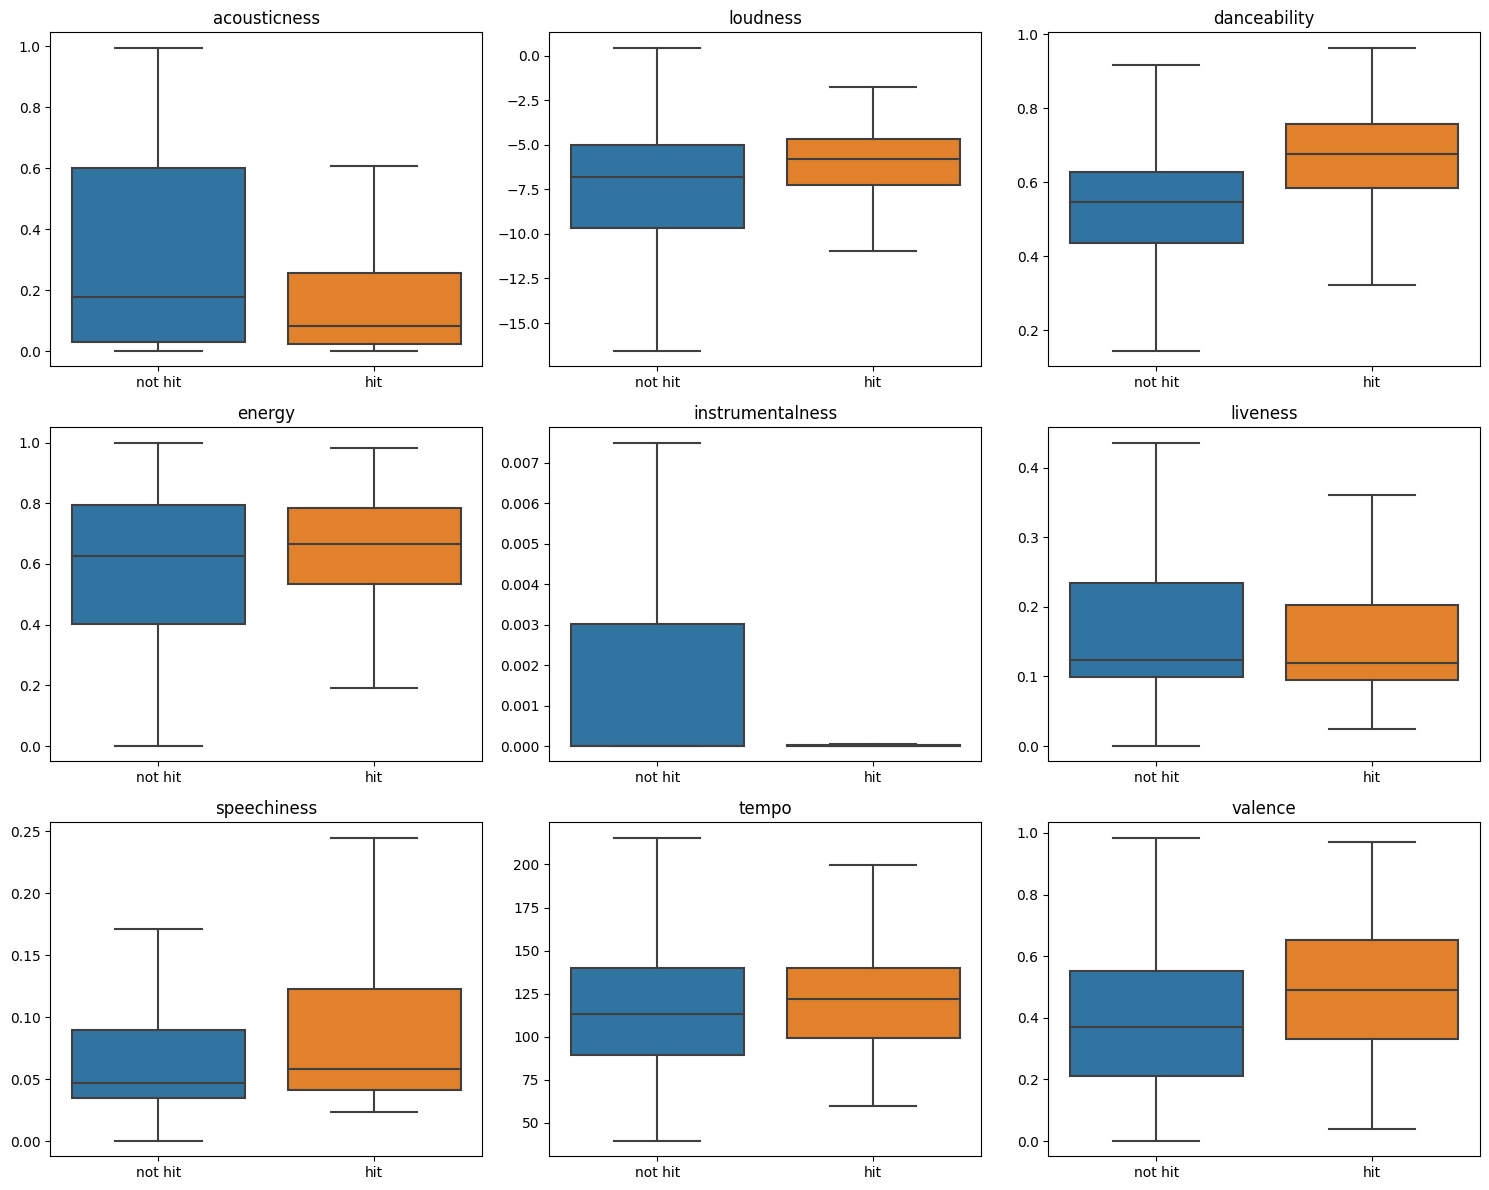

In [27]:
# Calculate the number of rows and columns for the subplot grid
n_rows = len(num_features) // 3
n_cols = 3

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes array for iteration
axes = axes.flatten()

# Loop through each feature and create box plots for each 'hit' value
for idx, (feature, ax) in enumerate(zip(num_features, axes)):
    sns.boxplot(x='hit', y=feature, data=df_filtered, ax=ax, showfliers=False)
    ax.set_title(f"{feature}")

    # Hide x and y-axis labels
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Set custom x-axis labels
    ax.set_xticks(ticks=[0, 1])
    ax.set_xticklabels(['not hit', 'hit'])

# Adjust layout and spacing
plt.tight_layout()
plt.show()


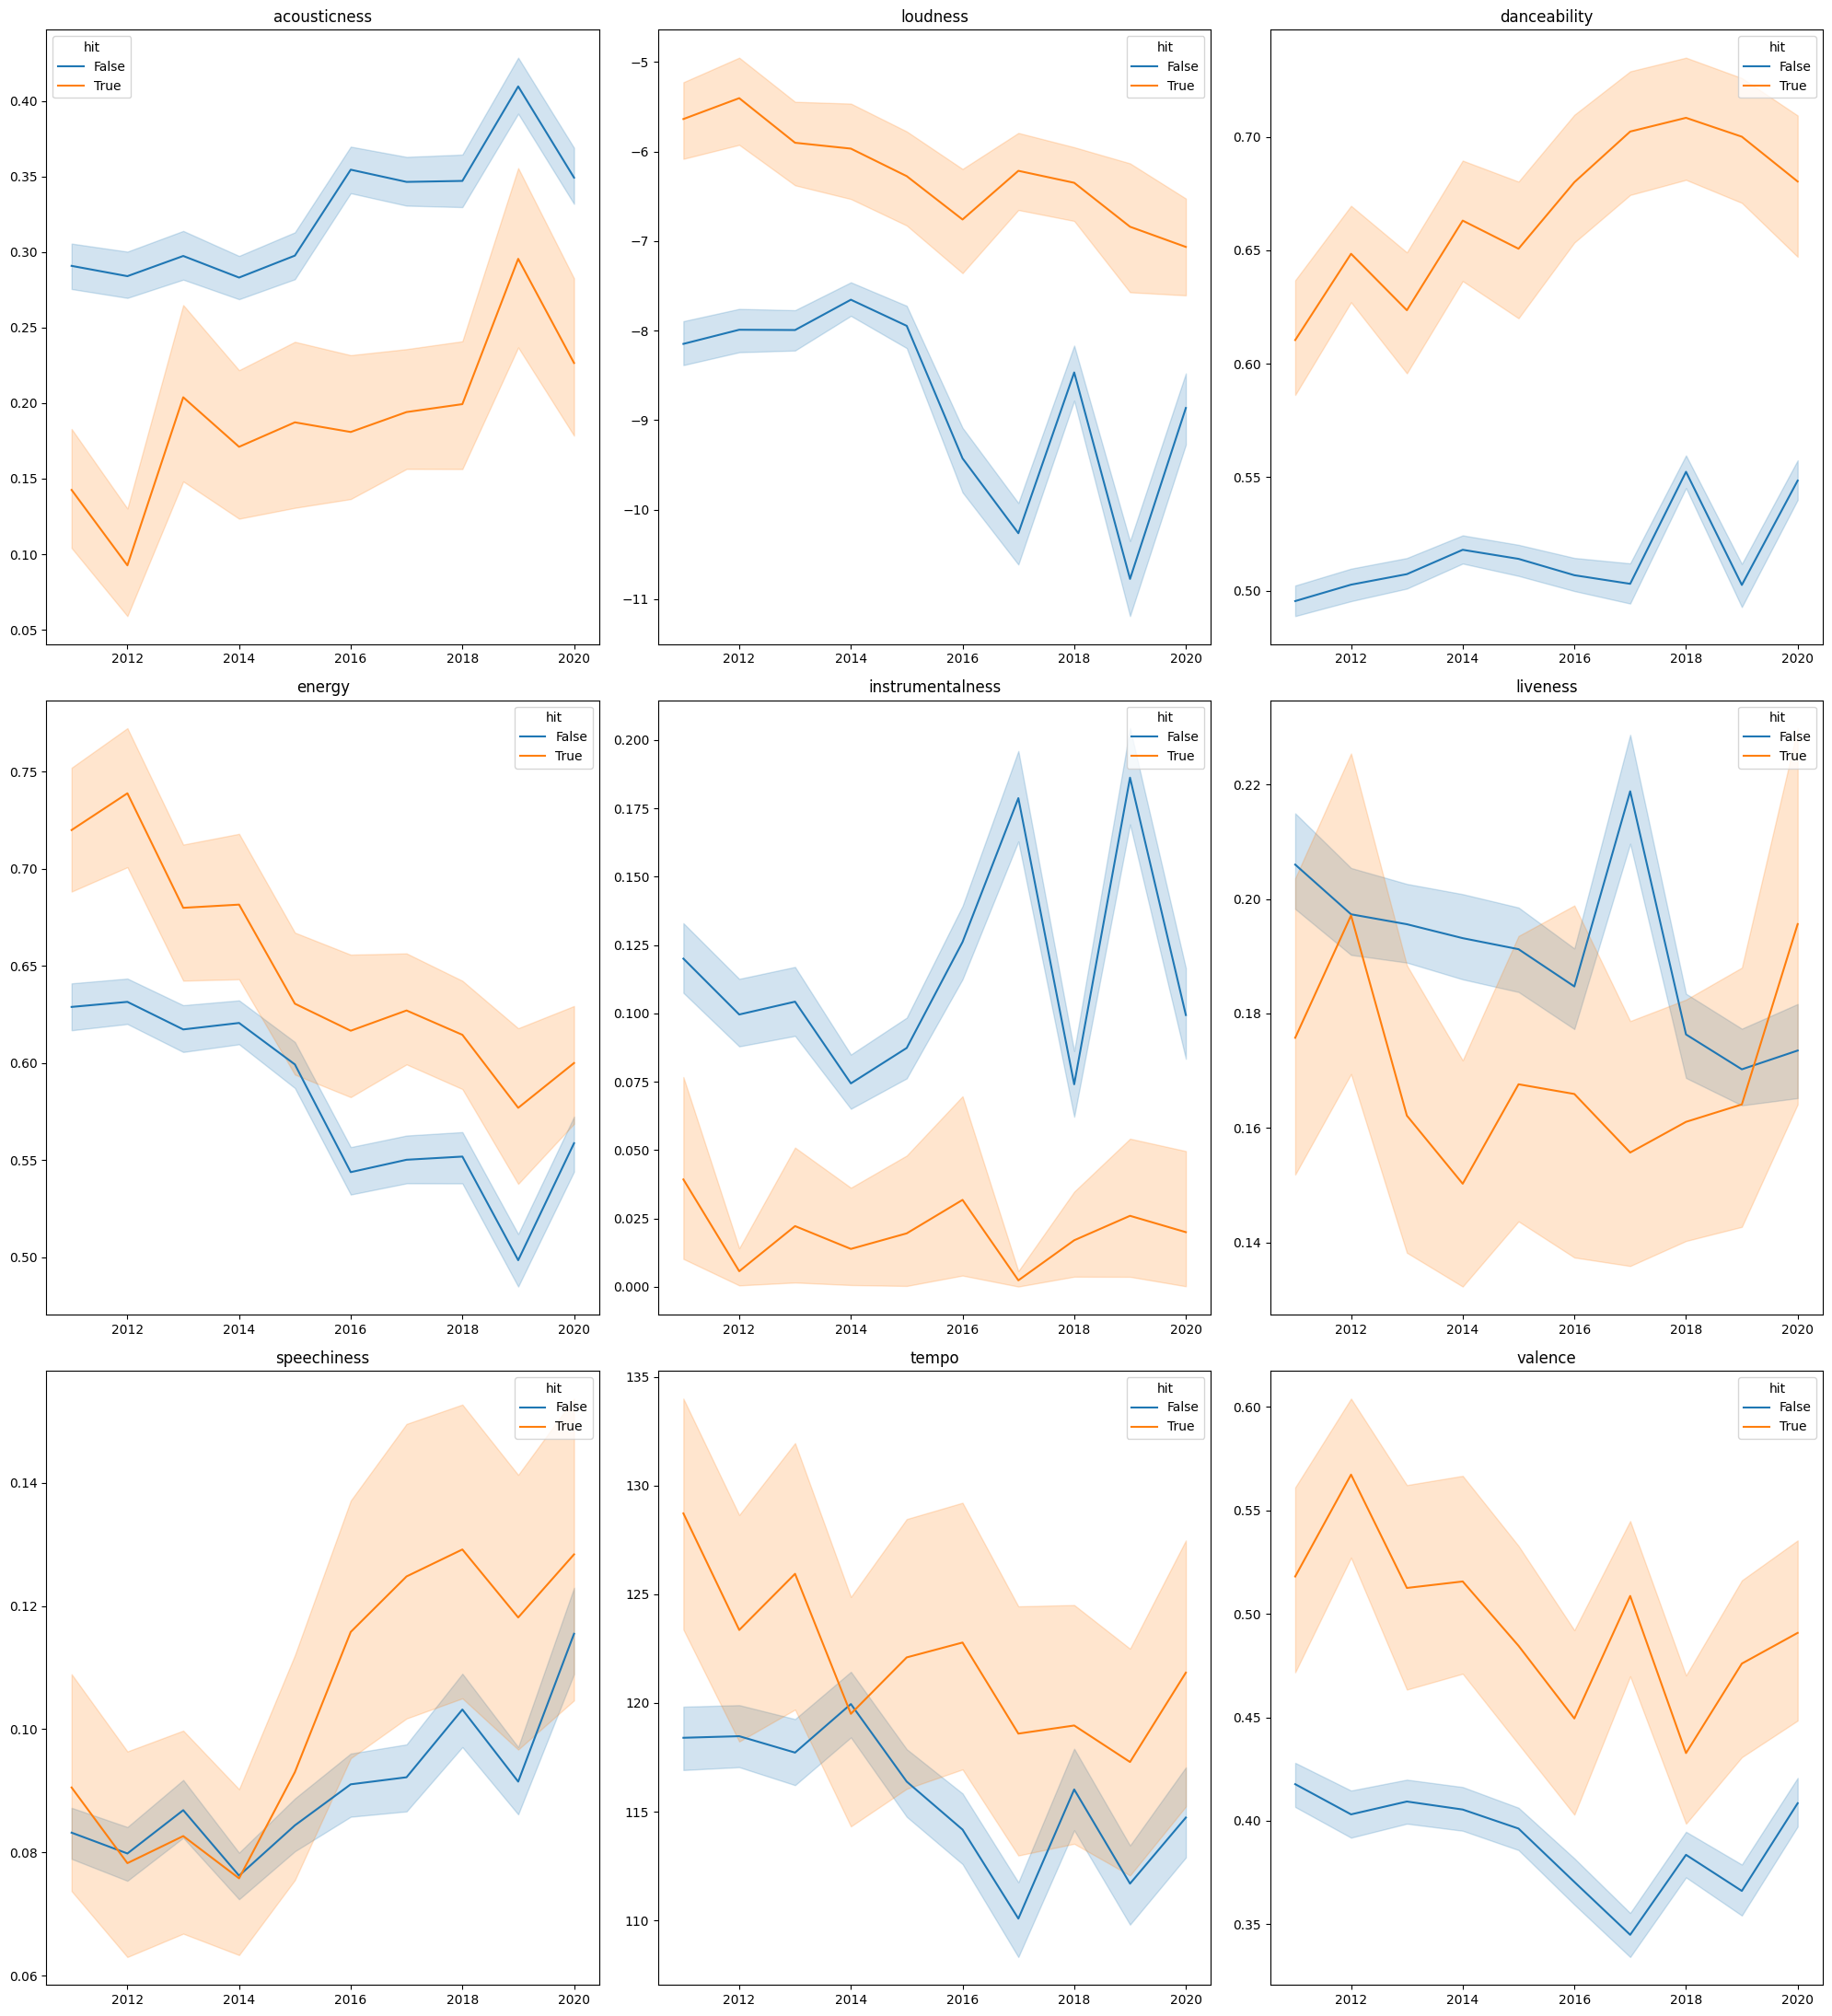

In [28]:
# Create subplots
fig, axes = plt.subplots(nrows=len(num_features)//3, ncols=3, figsize=(20, 22))

# Flatten the axes array for iteration
axes = axes.flatten()

# Loop through each feature and create a line plot for each year
for idx, feature in enumerate(num_features):
    ax = axes[idx]
    sns.lineplot(x='year', y=feature, hue='hit', data=df_filtered, ax=ax)
    ax.set_title(f"{feature}")

    # Hide x and y-axis labels
    ax.set_xlabel(None)
    ax.set_ylabel(None)

plt.tight_layout()
plt.show()


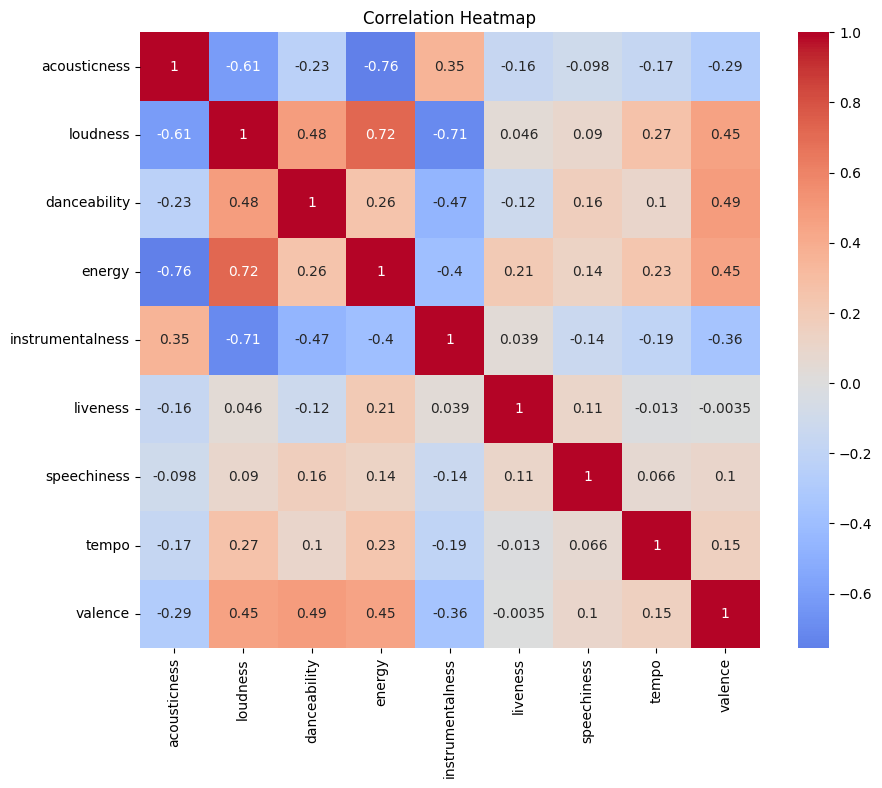

In [29]:
# Subset the dataframe using the columns in 'num_features'
subset_df = df_filtered[num_features]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [30]:
# EDA suggests danceability, instrumentalness and loudness could be amongst the main contributors to differentiate a hit from one that's not

## ML Modelling

In [31]:
# Class imbalance check
# Undersampling the majority class (not-hits) to create a 30-70 split

from imblearn.under_sampling import RandomUnderSampler

X = df_filtered[features]
y = df_filtered['hit']

# Instantiate the RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=0.42, random_state=2)

# Fit and apply the undersampler
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the distribution of classes after undersampling
print("Class distribution after undersampling:", Counter(y_resampled))

Class distribution after undersampling: Counter({False: 2157, True: 906})


In [32]:
# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['hit'] = y_resampled

In [33]:
# Get percentages of top 100 songs and others (class imbalance check)
print(df_resampled['hit'].value_counts(normalize=True)*100)

False    70.421156
True     29.578844
Name: hit, dtype: float64


In [34]:
# Check the lengths of the data series
for feature in features:  # Exclude 'top_100'
    x_length = len(df_resampled[feature])
    print(f"Length of {feature}: {x_length}")

Length of acousticness: 3063
Length of loudness: 3063
Length of danceability: 3063
Length of energy: 3063
Length of instrumentalness: 3063
Length of liveness: 3063
Length of speechiness: 3063
Length of tempo: 3063
Length of valence: 3063
Length of explicit: 3063


In [35]:
# Separating out the target variable

y = df_resampled['hit']
X = df_resampled.drop(['hit'], axis=1)

In [36]:
# Final datatype and null count check

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3063 entries, 8446 to 1187
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      3063 non-null   float64
 1   loudness          3063 non-null   float64
 2   danceability      3063 non-null   float64
 3   energy            3063 non-null   float64
 4   instrumentalness  3063 non-null   float64
 5   liveness          3063 non-null   float64
 6   speechiness       3063 non-null   float64
 7   tempo             3063 non-null   float64
 8   valence           3063 non-null   float64
 9   explicit          3063 non-null   bool   
dtypes: bool(1), float64(9)
memory usage: 242.3 KB


In [37]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [38]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0, stratify=y_tr)

In [39]:
# As each song feature is expressed on varying ranges, scaling them to avoid dominance by any one is crucial

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [40]:
# Get shape of each training, validation, and testing set
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape, y_train.shape, y_val.shape, y_test.shape

((1837, 10), (613, 10), (613, 10), (1837,), (613,), (613,))

In [41]:
# Function to calculate the required metrics for each model

def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    return accuracy, precision, recall, f1


### Logistic Regressor

In [42]:
# Instantiate the logistic regression classifier
log_reg = LogisticRegression(max_iter=1000, random_state=0)

# Define hyperparameters to tune
log_reg_params = {'C': [0.1, 1, 10],  # Regularization parameter
                  'solver': ['liblinear', 'lbfgs']}  # Algorithm to use in optimization

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
log_reg_cv = GridSearchCV(log_reg, log_reg_params, scoring=scoring, cv=5, refit='precision')

# Fit the model
log_reg_cv.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg_cv.predict(X_val_scaled)


In [43]:
# Display the scoring metrics

accuracy_log_reg, precision_log_reg, recall_log_reg, f1_log_reg = calculate_metrics(y_val, y_pred_log_reg)

# Create a dictionary with metric names as keys and their corresponding values
log_reg_metrics_dict = {
    'Accuracy': accuracy_log_reg,
    'Precision': precision_log_reg,
    'Recall': recall_log_reg,
    'F1 Score': f1_log_reg
}

# Convert the dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(log_reg_metrics_dict, index=['Logistic Regression'])

# Display the DataFrame
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.781403   0.704348  0.447514  0.547297


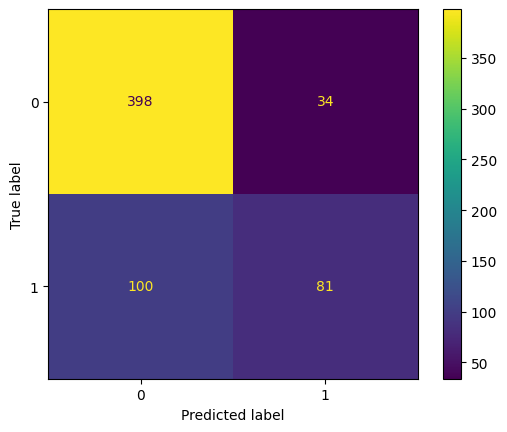

In [44]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred_log_reg)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [45]:
# In an ideal world, the principal diagonall would contain all the records but this is unfeasible
# In this scenario, I would prefer to minimize the top-right quadrant (false-positives) 
# as it would be more detrimental to spend large sums of money on producing a song that's predicted to be a hit but fails to do so

### Random Forest

In [46]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='precision')

In [47]:
%%time
rf_cv.fit(X_train_scaled, y_train)

CPU times: total: 1min 55s
Wall time: 2min 3s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='precision',
             scoring={'recall', 'f1', 'precision', 'accuracy'})

In [48]:
# Examine best recall score
rf_cv.best_score_

0.8830134342066346

In [49]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 7,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [50]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred_rf = rf_cv.best_estimator_.predict(X_val_scaled)

In [51]:
accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_metrics(y_val, y_pred_rf)

rf_metrics_dict = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}

# Create a new row for the Random Forest metrics
metrics_df.loc['Random Forest'] = rf_metrics_dict

# Display the updated DataFrame
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.781403   0.704348  0.447514  0.547297
Random Forest        0.797716   0.835294  0.392265  0.533835


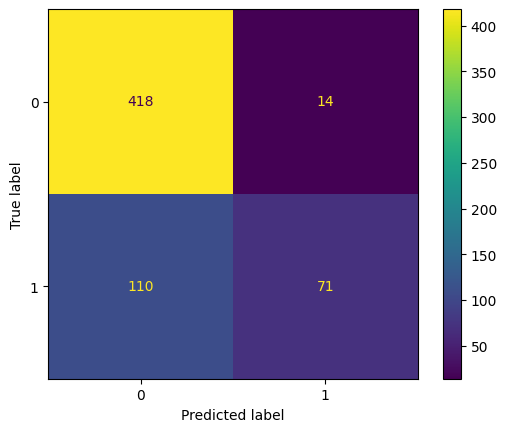

In [52]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred_rf)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

### XGBoost

In [53]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune

cv_params = {
    'max_depth': [4, 8, 12],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [300, 700],
    'scale_pos_weight': [1, 3]
}


# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='precision')

In [54]:
%%time
xgb_cv.fit(X_train_scaled, y_train)

CPU times: total: 50min 30s
Wall time: 3min 41s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 8, 12], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [300, 700],
                         'scale_pos_weight': [1, 3]},
             refit='precision',
             scoring={'recall', 'f1', 'precision', 'accuracy'})

In [55]:
xgb_cv.best_score_

0.9012934151879574

In [56]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300,
 'scale_pos_weight': 1}

In [57]:
#Evaluate XGBoost model
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val_scaled)

In [70]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = calculate_metrics(y_val, y_pred_xgb)

xgb_metrics_dict = {
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1 Score': f1_xgb
}

# Create a new row for the Random Forest metrics
metrics_df.loc['XG Boost'] = xgb_metrics_dict

# Round the values in the DataFrame to two decimal places
metrics_df = metrics_df.round(2)

# Display the updated DataFrame
print(metrics_df)

                     Accuracy  Precision  Recall  F1 Score
Logistic Regression      0.78       0.70    0.45      0.55
Random Forest            0.80       0.84    0.39      0.53
XG Boost                 0.80       0.86    0.39      0.53
XG Boost (Test)          0.81       0.87    0.41      0.56


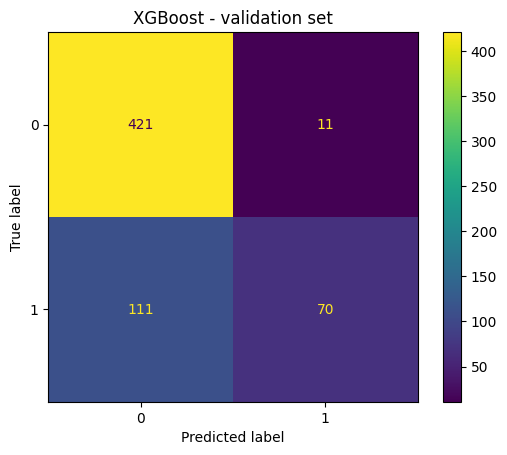

In [59]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred_xgb)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()

### Test Data

In [60]:
# Use champion model to predict on test data
y_pred_RF = rf_cv.best_estimator_.predict(X_test_scaled)

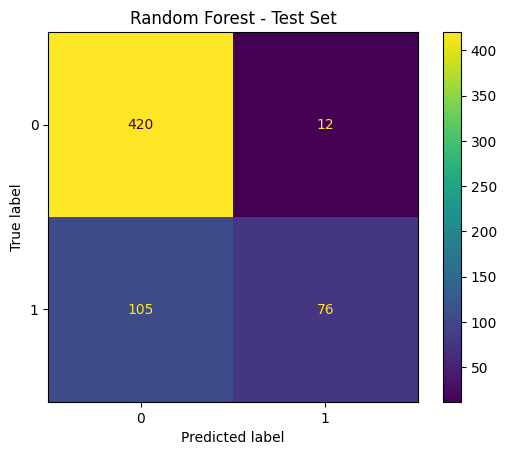

In [61]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_RF)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random Forest - Test Set');
plt.show()

In [62]:
# Use champion model to predict on test data
y_pred_XGB = xgb_cv.best_estimator_.predict(X_test_scaled)

In [69]:
accuracy_xgb_test, precision_xgb_test, recall_xgb_test, f1_xgb_test = calculate_metrics(y_test, y_pred_XGB)

xgb_test_metrics_dict = {
    'Accuracy': accuracy_xgb_test,
    'Precision': precision_xgb_test,
    'Recall': recall_xgb_test,
    'F1 Score': f1_xgb_test
}

# Create a new row for the Random Forest metrics
metrics_df.loc['XG Boost (Test)'] = xgb_test_metrics_dict

# Round the values in the DataFrame to two decimal places
metrics_df = metrics_df.round(2)

# Display the updated DataFrame
print(metrics_df)

                     Accuracy  Precision  Recall  F1 Score
Logistic Regression      0.78       0.70    0.45      0.55
Random Forest            0.80       0.84    0.39      0.53
XG Boost                 0.80       0.86    0.39      0.53
XG Boost (Test)          0.81       0.87    0.41      0.56


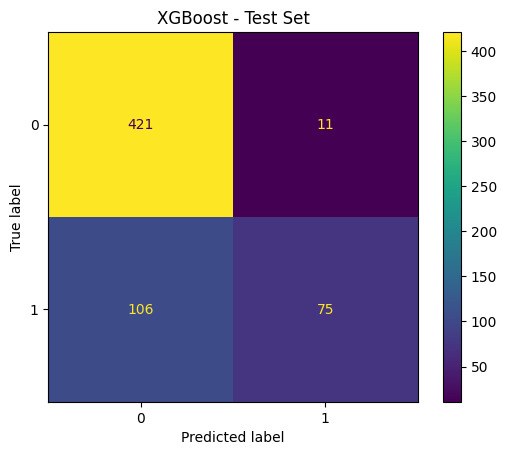

In [65]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_XGB)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - Test Set');
plt.show()

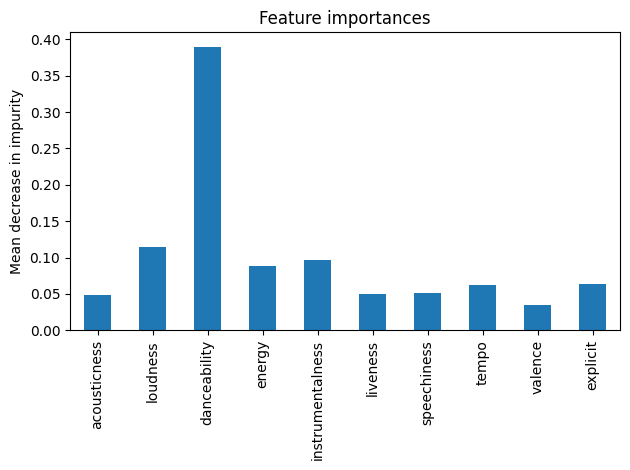

In [66]:
importances = xgb_cv.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()